In [7]:
import numpy as np
import matplotlib.pylab as plt
import pickle
from scipy import signal,interpolate
from apis.imaging_classes import save_disp_imgs,bootstrap_disp
from modules.utils import extract_ridge_ref_idx,plot_disp_curves

# Load saved surface wave windows associated with vehicle states and speeds

In [2]:
# Define the file name using an f-string to include the value of _x0: pivot.
_x0 = 700
tracking_offset = 150
_start_x = _x0 - tracking_offset
_end_x = _x0 + tracking_offset
file_name = f"data/sw_data/{_x0}.pkl"

# Open the file in binary read mode
with open(file_name, "rb") as f:
    # Load the pickled data from the file.
    windows_all = pickle.load(f)  # Load the 'windows_all' surface wave window data from the file.
    das_veh_states = pickle.load(f)  # Load the 'das_veh_states' data from the file.
    veh_speed = pickle.load(f)  # Load the 'veh_speed' data from the file.

# Get surface wave windows with different vehicle weights

## Use majority vehicle weights and speeds

In [3]:
# Calculate the mean along the first axis
das_veh_states_mean = []
for das_veh in das_veh_states:
    mean_tmp = signal.detrend(signal.savgol_filter(das_veh.mean(0),101,3))
    mean_tmp = mean_tmp-mean_tmp[0]
    das_veh_states_mean.append(mean_tmp)
# Calculate the peaks of the mean values.
peaks = np.max(np.abs(das_veh_states_mean), 1)

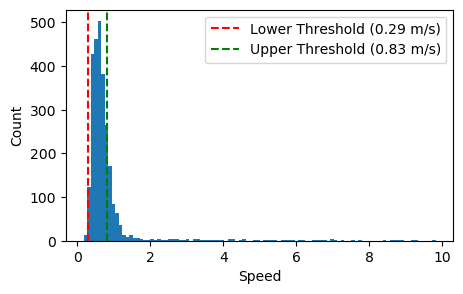

In [4]:
# Create a histogram of vehicle speeds.
fig = plt.figure(figsize=(5, 3))
plt.hist(peaks, bins=100)
plt.xlabel('Speed')
plt.ylabel('Count')
# Create a histogram of vehicle speeds.
hist, bins = np.histogram(peaks, bins=100)
# Find the bin with the highest frequency (the mode).
mode_peak = bins[np.argmax(hist)]
# Calculate the standard deviation of the vehicle speeds.
sigma = np.std(peaks)
# Define threshold values based on one sigma away from the mode.
lower_limit = mode_peak - 0.3*sigma
upper_limit = mode_peak + 0.3*sigma
# Define a condition to select speeds within one sigma of the mode.
peak_idx = np.where((peaks >= lower_limit) & (peaks <= upper_limit))[0]

# Plot vertical lines to mark the threshold values.
plt.axvline(lower_limit, color='r', linestyle='--', label=f'Lower Threshold ({lower_limit:.2f} m/s)')
plt.axvline(upper_limit, color='g', linestyle='--', label=f'Upper Threshold ({upper_limit:.2f} m/s)')
# Create a legend to label the threshold lines.
plt.legend()

# Filter das_veh_states_mean and windows_all_rm to only include elements with matching indices in speed_idx.
veh_speed = np.array([i for j, i in enumerate(veh_speed) if j in peak_idx])
das_veh_states = [i for j, i in enumerate(das_veh_states) if j in peak_idx]
windows_all = [i for j, i in enumerate(windows_all) if j in peak_idx]

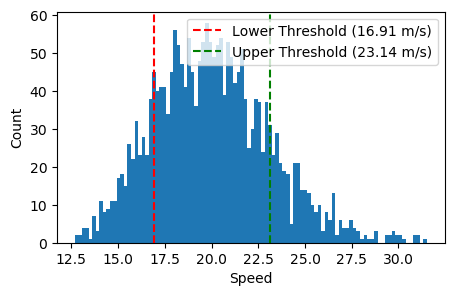

In [5]:
# Define threshold values based on one sigma away from the mode.
lower_limit = np.mean(veh_speed) - 1*np.std(veh_speed)
upper_limit = np.mean(veh_speed) + 1*np.std(veh_speed)
# Define a condition to select speeds within one sigma of the mode.
speed_idx = np.where((veh_speed >= lower_limit) & (veh_speed <= upper_limit))[0]

# Create a histogram of vehicle speeds.
fig = plt.figure(figsize=(5, 3))
plt.hist(veh_speed, bins=100)
plt.xlabel('Speed')
plt.ylabel('Count')
# Plot vertical lines to mark the threshold values.
plt.axvline(lower_limit, color='r', linestyle='--', label=f'Lower Threshold ({lower_limit:.2f} m/s)')
plt.axvline(upper_limit, color='g', linestyle='--', label=f'Upper Threshold ({upper_limit:.2f} m/s)')
# Create a legend to label the threshold lines.
plt.legend()

# Filter das_veh_states_mean and windows_all_rm to only include elements with matching indices in speed_idx.
das_veh_states = [i for j, i in enumerate(das_veh_states) if j in speed_idx]
windows_all = [i for j, i in enumerate(windows_all) if j in speed_idx]
veh_speed = np.array([i for j, i in enumerate(veh_speed) if j in peak_idx])

## Spliting small, mid, and large size vehicles

### Auto-correlation to estimation wheelbase

In [8]:
# Initialize a list to store bandpass-filtered das_veh_states.
das_veh_states_bp = []

# Set filter parameters.
order = 10
flo = 1
fhi = 3
# Design a high-pass Butterworth filter.
sos = signal.butter(order, fhi, 'hp', fs=250, output='sos')
# Apply the high-pass filter to each das_veh in das_veh_states and store the filtered data.
for das_veh in das_veh_states:
    data = signal.sosfiltfilt(sos, das_veh, axis=1)
    das_veh_states_bp.append(np.array(data))
    
# Initialize lists to store auto-correlation results and lags.
auto_corr = []
lags_uni = np.linspace(2, 5, 301)
# Calculate auto-correlation for each das_hf and veh_sp pair.
for das_hf, veh_sp in zip(das_veh_states_bp, veh_speed):
    # Extract the 15th channel of das_hf data.
    hf_tmp = das_hf[15, :]    
    # Normalize the data.
    hf_tmp = (hf_tmp - hf_tmp.mean()) / hf_tmp.std()
    # Calculate the lags and scale them with veh_sp.
    lags = signal.correlation_lags(len(hf_tmp), len(hf_tmp))
    lags_len = lags / 250 * veh_sp    
    # Calculate auto-correlation for the 15th channel.
    corr = signal.correlate(hf_tmp, hf_tmp)    
    # Iterate through channels 16 to 24 and accumulate auto-correlation.
    for cha_num in range(16, 25):
        corr_norm = signal.correlate(das_hf[cha_num, :], das_hf[cha_num, :])
        corr_norm = (corr_norm - corr_norm.mean()) / corr_norm.std()
        corr += corr_norm    
    # Interpolate the correlation to uniform lags and store the result.
    f = interpolate.interp1d(lags_len, corr)
    corr_inter = f(lags_uni)
    auto_corr.append(corr_inter)
# Find the index of maximum absolute value in each auto-correlation and the corresponding sizes.
size_idx = np.argmax(np.abs(auto_corr), 1)
sizes = lags_uni[size_idx]

# Filter data based on the size criteria 2-5 meter.
e2 = np.where((np.array(sizes) > 2) & (np.array(sizes) < 5))[0]
sizes = np.array([i for j, i in enumerate(sizes) if j in e2])
das_veh_states = [i for j, i in enumerate(das_veh_states) if j in e2]
windows_all = [i for j, i in enumerate(windows_all) if j in e2]


Number of Large vehicles: 212
Number of Mid vehicles: 938
Number of Small vehicles: 203


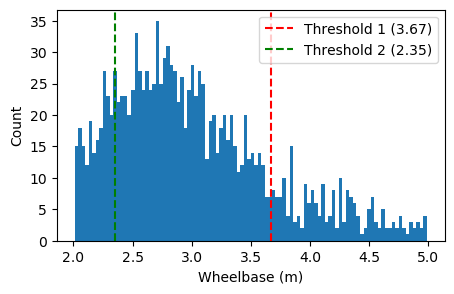

In [9]:
# Create a histogram of the sizes.
fig = plt.figure(figsize=(5, 3))
n, bins, patches = plt.hist(sizes, bins=100)
plt.xlabel('Wheelbase (m)')
plt.ylabel('Count')

# Define the threshold values.
threshold_1 = np.mean(sizes) + np.std(sizes)
threshold_2 = np.mean(sizes) - np.std(sizes)
# Plot vertical lines to mark the thresholds.
plt.axvline(threshold_1, color='r', linestyle='--', label=f'Threshold 1 ({threshold_1:.2f})')
plt.axvline(threshold_2, color='g', linestyle='--', label=f'Threshold 2 ({threshold_2:.2f})')
# Create a legend to label the threshold lines.
plt.legend()

# Classify peaks into large, mid, and small based on the conditions.
large_idx = np.where(sizes > threshold_1)[0]
mid_idx = np.where((sizes <= threshold_1) & (sizes > threshold_2))[0]
small_idx = np.where(sizes <= threshold_2)[0]

# Print the number of elements in each category.
print(f'Number of Large vehicles: {len(large_idx)}')
print(f'Number of Mid vehicles: {len(mid_idx)}')
print(f'Number of Small vehicles: {len(small_idx)}')

In [10]:
windows_large = []  # For peaks greater than 2.
windows_mid = []    # For peaks less than or equal to 2 but greater than mode.
windows_small = []  # For peaks smaller than mode.

# Iterate through heavy_idx, mid_idx, and small_idx to collect corresponding surface wave windows.
for k in large_idx:
    windows_large.append(windows_all[k])
for k in mid_idx:
    windows_mid.append(windows_all[k])
for k in small_idx:
    windows_small.append(windows_all[k])

# Imaging for different weights

## Plot

figures/700/sg_large_cars.png has saved...
saving figures/700/disp_large_cars_no_norm.png...
saving figures/700/disp_large_cars_no_enhance.png...
saving figures/700/disp_large_cars.png...
figures/700/sg_midsize_cars.png has saved...
saving figures/700/disp_midsize_cars_no_norm.png...
saving figures/700/disp_midsize_cars_no_enhance.png...
saving figures/700/disp_midsize_cars.png...
figures/700/sg_small_cars.png has saved...
saving figures/700/disp_small_cars_no_norm.png...
saving figures/700/disp_small_cars_no_enhance.png...
saving figures/700/disp_small_cars.png...


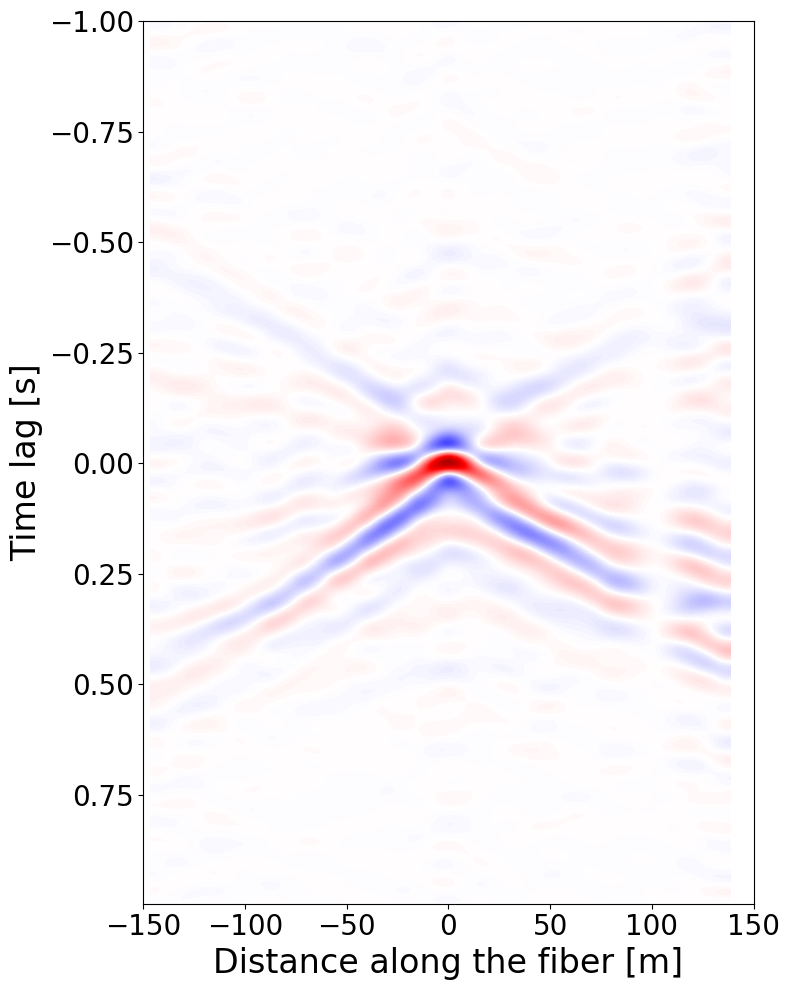

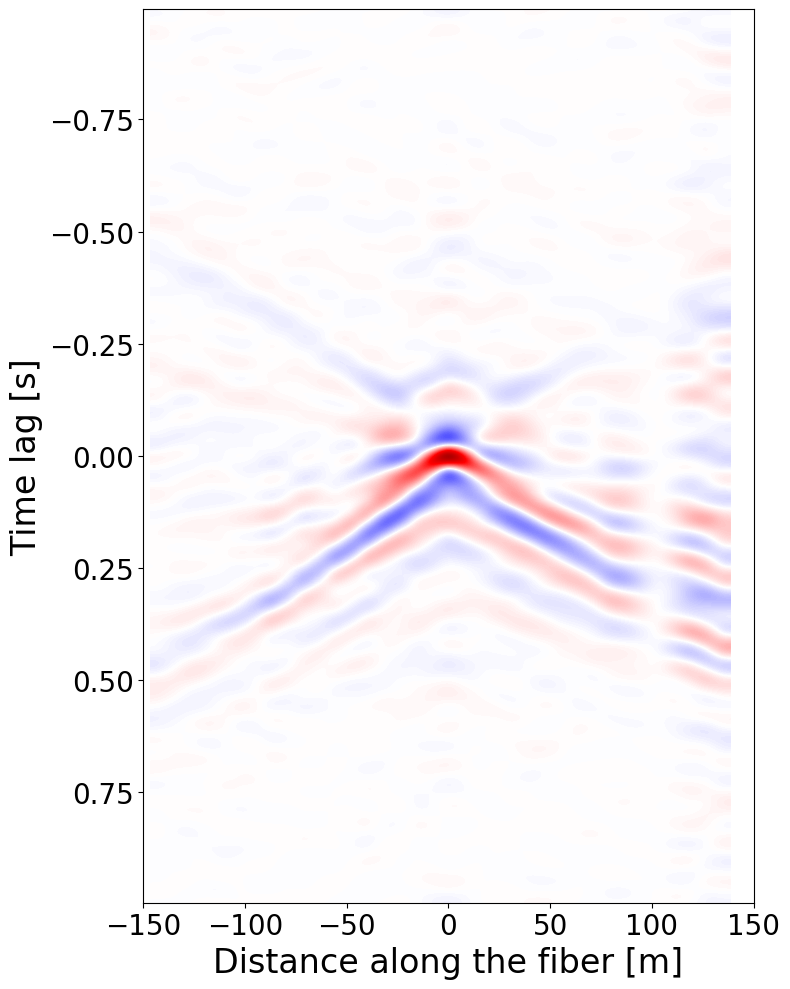

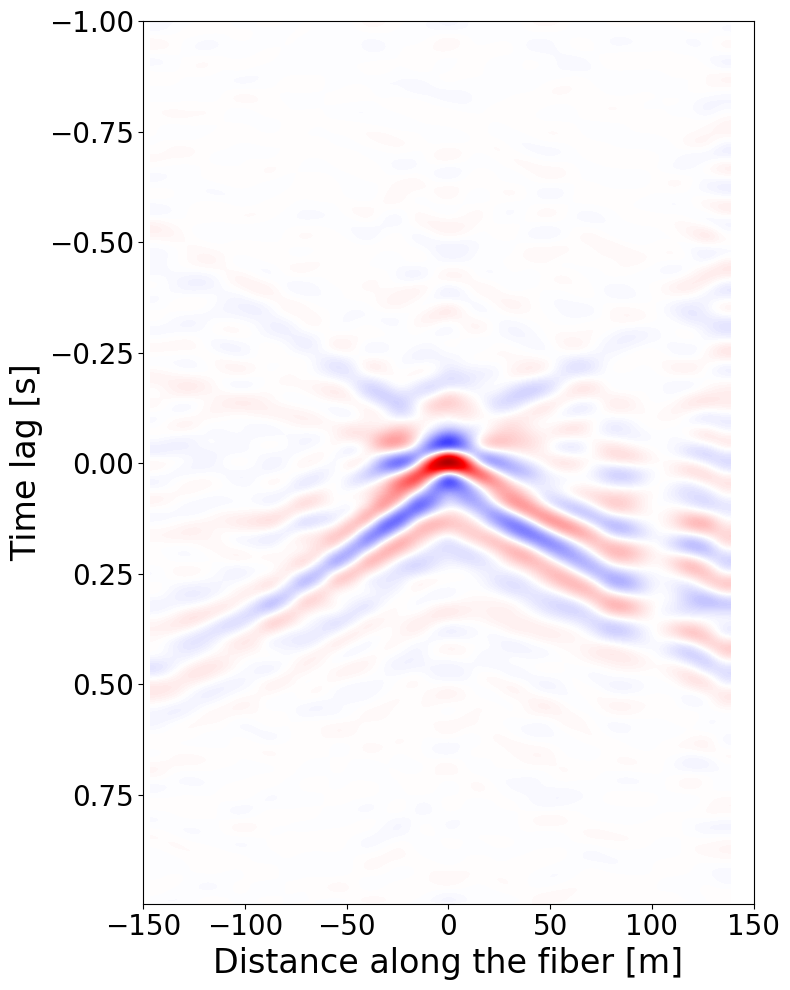

In [11]:
_min_win = np.min([len(large_idx),len(mid_idx),len(small_idx)])
images_heavy = save_disp_imgs(windows_large, 'large', _min_win, _x0, _start_x, _end_x, tracking_offset, fig_dir='figures')
images_mid = save_disp_imgs(windows_mid, 'midsize', _min_win, _x0, _start_x, _end_x, tracking_offset, fig_dir='figures')
images_light = save_disp_imgs(windows_small, 'small', _min_win, _x0, _start_x, _end_x, tracking_offset, fig_dir='figures')

## Save image files

In [12]:
# file_name = f'data/saved_disp/{_x0}_images_sizes.pkl'
# with open(file_name, 'wb') as file:
#     pickle.dump(images_heavy, file)
#     pickle.dump(images_mid, file)
#     pickle.dump(images_light, file)
#     print(f'Object successfully saved to "{file_name}"')

## Bootstrapping

In [13]:
bt_times = 20
bt_size = 20
sigma = 25
ref_freq_idx = 80
freq_lb = 2.5
freq_ub = 14
ridge_vel_small,freqs = bootstrap_disp(windows_small,bt_size,bt_times,sigma,_x0,_start_x,_end_x,ref_freq_idx,freq_lb,freq_ub)
ridge_vel_large,_ = bootstrap_disp(windows_large,bt_size,bt_times,sigma,_x0,_start_x,_end_x,ref_freq_idx,freq_lb,freq_ub)
ridge_vel_mid,_ = bootstrap_disp(windows_mid,bt_size,bt_times,sigma,_x0,_start_x,_end_x,ref_freq_idx,freq_lb,freq_ub)

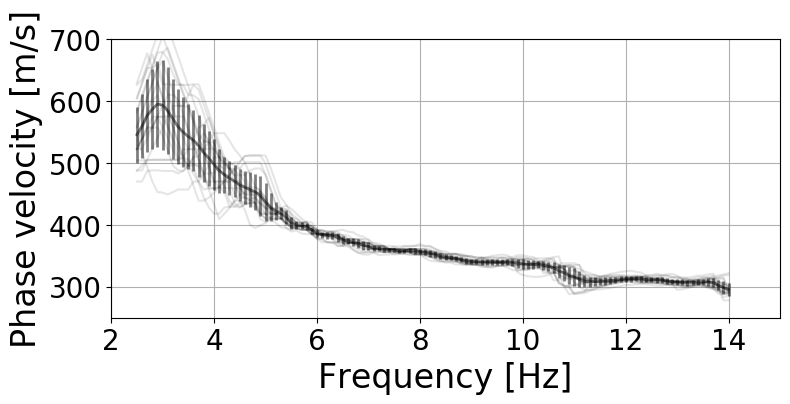

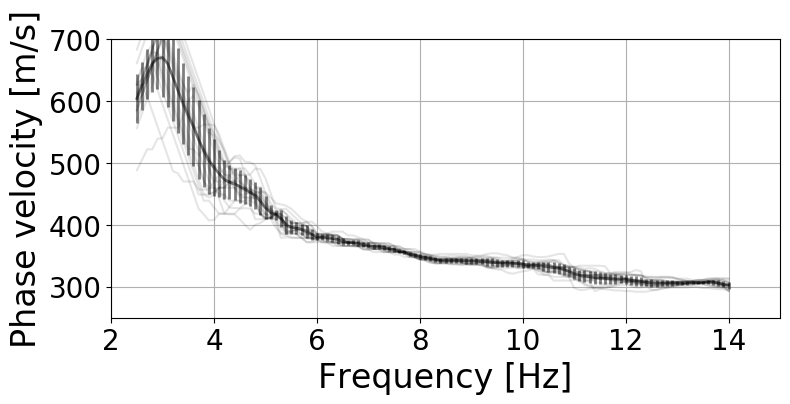

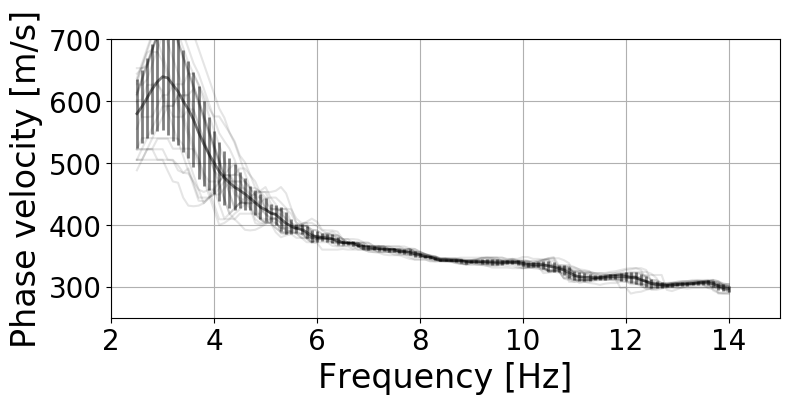

In [14]:
freqs_lu = freqs[(freqs>=freq_lb)&(freqs<freq_ub)]
plot_disp_curves(freqs_lu, ridge_vel_large)
plot_disp_curves(freqs_lu, ridge_vel_mid)
plot_disp_curves(freqs_lu, ridge_vel_small)

In [18]:
file_name = f'data/{_x0}_sizes.npz'
np.savez(file_name, freqs=freqs_lu, vels_large=ridge_vel_large, 
         vels_mid=ridge_vel_mid, vels_small=ridge_vel_small)